# 5. Quanvolutional Neural Networks

Install pre-requisites required for this notebook to run

**Note:** This step is optional if you are running this notebook from the docker container

In [10]:
using Pkg;

Pkg.add("PyCall");
Pkg.add("AWS");

Pkg.add("Flux");
Pkg.add("MLDatasets");

Pkg.add("Plots");
Pkg.add("PyPlot");
Pkg.add("Colors");
Pkg.add("ProgressMeter");

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Chan

Import all required libraries

In [11]:
using Base: @kwdef
using Colors
using Plots
using ProgressMeter;

using Flux;
using Flux: onehotbatch, onecold, onehot, @epochs;
using Flux.Data: DataLoader
using Flux.Losses: logitcrossentropy

using MLDatasets

using PyCall
using AWS: @service
@service S3;
@service Braket;
@service STS;

# Braket imports
awsbraket = pyimport("braket.aws");
devices   = pyimport("braket.devices");
circuit   = pyimport("braket.circuits");

We are going to use the LocalSimulator to run this notebook, so that we don't incur any cost.

In [12]:
qpu = devices.LocalSimulator();

## The Dataset

We will use the FashionMNIST dataset to demonstrate Quanvolutional Neural Networks. [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In [218]:
TRAIN_SIZE = 10; #60000;
TEST_SIZE = 10 #10000;
BATCH_SIZE = 10;
SHUFFLE = true;
LABELS = ["T-Shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"];
NUM_CLASSES = 10;
IMAGE_SIZE = (28,28,1);
DEVICE = cpu;
PRE_PROCESS = true;
EPOCHS=100;
CONV_SIZE = 4;

In [219]:
xtrain, ytrain = MLDatasets.FashionMNIST.traindata(Float32);
xtest, ytest = MLDatasets.FashionMNIST.testdata(Float32);

Let's sample a few images from this dataset

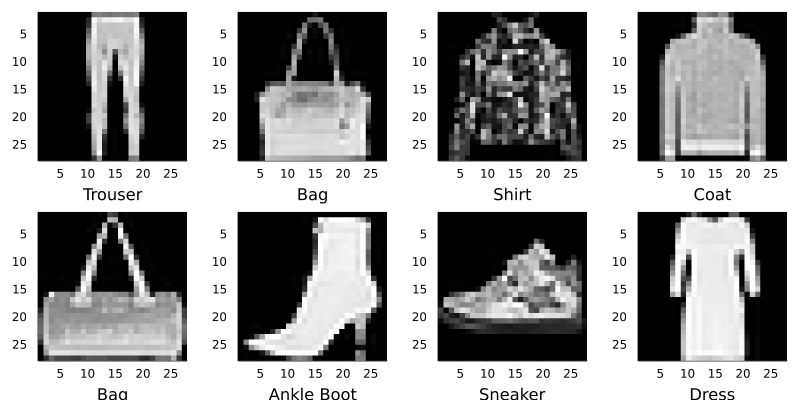

In [220]:
x = []
for i in 1:8
    idx = rand(1:60000)
    image = xtrain[:,:,idx]
    label = ytrain[idx]
    push!(x,plot(Gray.(image'), size=(100, 100), xlabel=LABELS[label + 1]))
end

plot(x..., layout=(2,4), size = (800,400))

## Variational Circuits as Feature Extractors

Similar to how CNNs are used as a feature extractor in classical deep learning, we can use variational quantum circuits in place of the Convolutional filters. 

![](assets/qnncircuit.png)


The idea here is that we encode the pixels of the image in each local $2 \times 2$ region of the image as angles of rotation around the y-axis ($R_y$ gate). We pass these encoded pixels through a random quantum circuit and translate them back to a classical pixel through a measurement of each qubit. Each qubit output is now considered as a separate channel in the pixel position of the convolved filter. Our 28x28 2-D image will be convolved into a $14\times14\times4$ 3-D volume. We can now apply classical ML techniques on these extracted features for our task (classification etc.).

In [221]:
rand_params = rand(-pi:pi, 4)
function random_layer(target_circuit)
    target_circuit.add(circuit.Circuit().rx(0, rand_params[1]))
    target_circuit.add(circuit.Circuit().rz(3, rand_params[2]))
    target_circuit.add(circuit.Circuit().cnot(2,1))
    target_circuit.add(circuit.Circuit().cnot(3,0))
    target_circuit.add(circuit.Circuit().ry(0,rand_params[3]))
    target_circuit.add(circuit.Circuit().rx(0,rand_params[4]))
    
    return target_circuit
end;

In [222]:
function get_filter(phi)
    conv_filter = circuit.Circuit()
    
    for wire in 1:CONV_SIZE
        conv_filter.add(circuit.Circuit().ry(wire - 1, pi * phi[wire]))
    end

    conv_filter = random_layer(conv_filter)
    
    conv_filter.expectation(observable=circuit.Observable.Z())
    
    return conv_filter 
end;

In [223]:
println(get_filter([1,2,3,4]).diagram())

T  : |   0    |    1    |2|    3    |   4    | Result Types |
                                                             
q0 : -Ry(3.14)-Rx(1.86)--X-Ry(-1.14)-Rx(2.86)-Expectation(Z)-
                         |                    |              
q1 : -Ry(6.28)-X---------|--------------------Expectation(Z)-
               |         |                    |              
q2 : -Ry(9.42)-C---------|--------------------Expectation(Z)-
                         |                    |              
q3 : -Ry(12.6)-Rz(-2.14)-C--------------------Expectation(Z)-

T  : |   0    |    1    |2|    3    |   4    | Result Types |


We can now pre-process the dataset by applying our quanvolutional filter on each $2\times2$ region of the image.

In [224]:
function quanv(image)
    out = zeros(14, 14, 4)
    for j = range(1, 28, step=2)
        conv_filter = nothing
        for k = range(1, 28, step=2)
            conv_filter = get_filter([
                    image[j, k],
                    image[j, k + 1],
                    image[j + 1, k],
                    image[j + 1, k + 1]
            ])
            qonv = qpu.run(conv_filter, shots=0).result().result_types[1].value
            for c in 1:4
                out[ceil(Int32, j/2), ceil(Int32, k/2), c] = qonv[c]
            end
        end
    end
    
    return out
end;

Let's apply the quanvolution to each image in our training set:

In [225]:
qxtrain = zeros(14, 14, 4, TRAIN_SIZE)
qxtest = zeros(14, 14, 4, TEST_SIZE)

plots = []

for i in 1:TRAIN_SIZE
    qxtrain[:,:,:, i] = quanv(xtrain[:,:,i])
end

for i in 1:TEST_SIZE
    qxtest[:,:,:, i] = quanv(xtest[:,:,i])
end

Lets sample a few images to see how the quanvolutional filter modified our images:

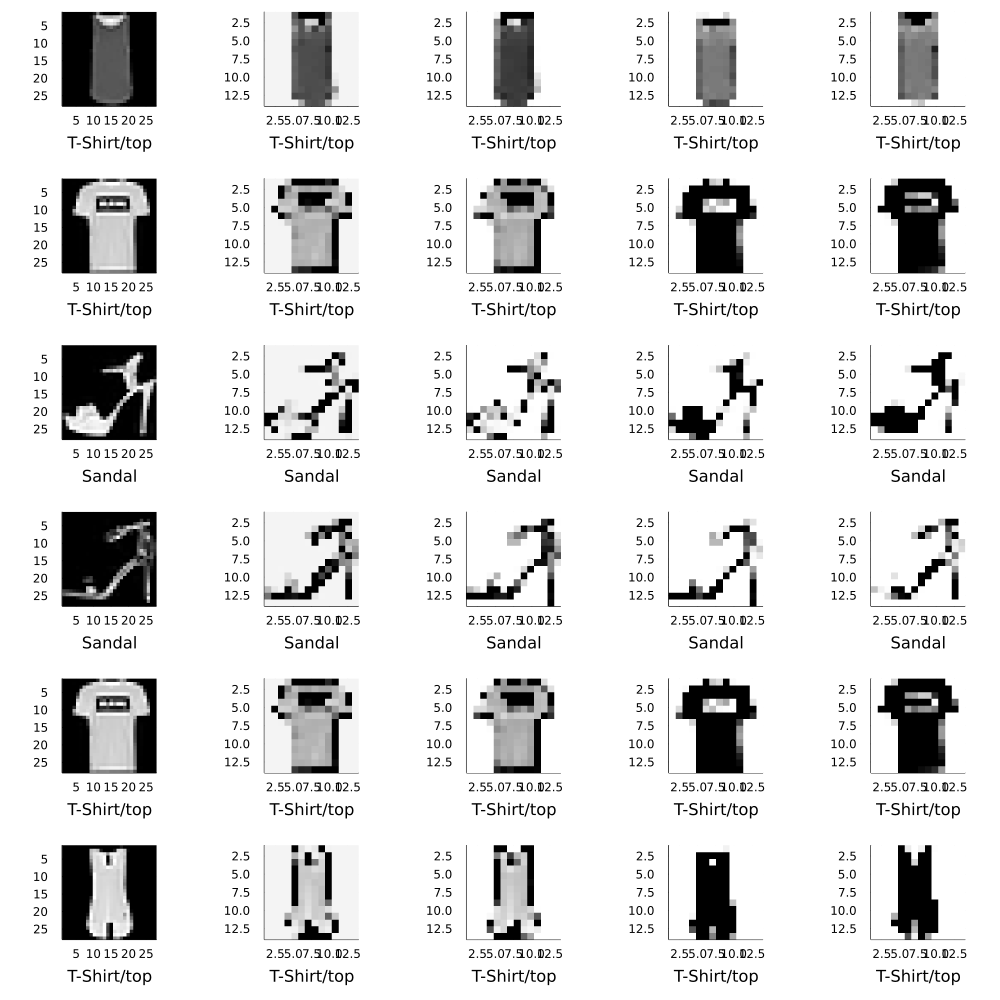

In [215]:
x = []
for i in 1:6
    idx = rand(1:TRAIN_SIZE)
    image = xtrain[:,:,idx]
    label = ytrain[idx]
    push!(x,plot(Gray.(image'), size=(100, 100),xlabel=LABELS[label+1]))
    for j in 1:4
        image = qxtrain[:,:,j,idx]
        push!(x,plot(Gray.(image'), size=(100, 100),xlabel=LABELS[label+1]))
    end
end

plot(x...,  layout=(6,5), size = (1000,1000))

In [226]:
train_loader = DataLoader((qxtrain[:, :, :, 1:TRAIN_SIZE], ytrain[1:TRAIN_SIZE]), batchsize=BATCH_SIZE, shuffle=SHUFFLE);
test_loader = DataLoader((qxtest[:, :, :, 1:TEST_SIZE], ytest[1:TEST_SIZE]), batchsize=BATCH_SIZE, shuffle=SHUFFLE);

## Model Training

Since this a multi-label classification scenario, we use the cross-entropy loss to measure how far away we are from the ideal output. 

In [227]:
function loss_and_accuracy(data_loader, model, device)
           acc = 0
           ls = 0.0f0
           num = 0
           for (x, y) in data_loader
               x, y = device(x), device(y)
               y = hcat(map((y) -> onehot(y, 0:9), y)...)
               ŷ = model(x)
               ls += logitcrossentropy(ŷ, y, agg=sum)
               acc += sum(onecold(ŷ) .== onecold(y))
               num +=  size(x, 2)
           end
           return ls / num, acc / num
end;

We have a straightforward model with 2 fully-connected dense layers, followed by a softmax.

In [228]:
function build_model(; imgsize=IMAGE_SIZE, nclasses=NUM_CLASSES)
    return Chain(
        Flux.flatten,
        Dense(prod(IMAGE_SIZE), 32, relu),
        Dense(32, nclasses),
        softmax
    )
end;
model = build_model() |> DEVICE;

We use the ADAM optimizer along with the model we defined above to train our model on the quanvolved images:

In [237]:
function optimize(; model, train_loader, test_loader, epochs=EPOCHS, device=DEVICE)
    opt = ADAM(3e-4);
    ps = Flux.params(model);
    trace = Dict("train" => Dict("loss" => [], "accuracy" => []), "test" => Dict("loss" => [], "accuracy" => []))
    @showprogress for epoch in 1:epochs
        for (x, y) in train_loader
            x, y = device(x), device(y) # transfer data to device
            y = hcat(map((y) -> onehot(y, 0:9), y)...)
            gs = gradient(() -> logitcrossentropy(model(x), y), ps) # compute gradient
            Flux.Optimise.update!(opt, ps, gs) # update parameters
        end
        train_loss, train_acc = loss_and_accuracy(train_loader, model, device);
        test_loss, test_acc = loss_and_accuracy(test_loader, model, device);
        push!(trace["train"]["loss"], train_loss)
        push!(trace["train"]["accuracy"], train_acc)
        push!(trace["test"]["loss"], test_loss)
        push!(trace["test"]["accuracy"], test_acc)
    end
    return trace;
end;
trace = optimize(model=model, train_loader=train_loader, test_loader=test_loader);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


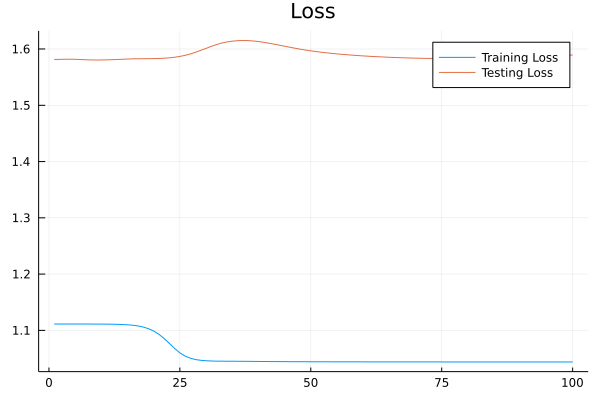

In [248]:
plot([trace["train"]["loss"], trace["test"]["loss"]], title="Loss", labels=["Training Loss" "Testing Loss"])

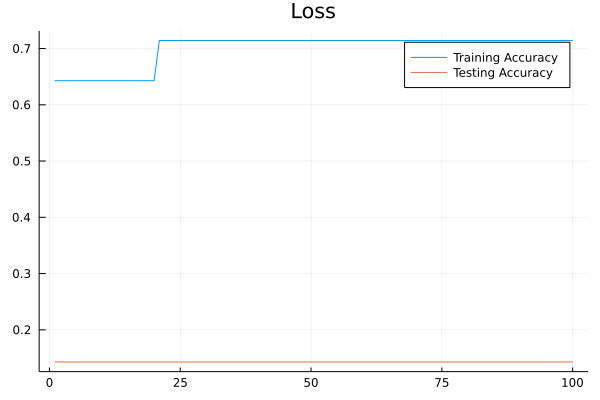

In [249]:
plot([trace["train"]["accuracy"], trace["test"]["accuracy"]], title="Loss", labels=["Training Accuracy" "Testing Accuracy"])

## Suggestions for Further Exploration

- Can you design a circuit that implements one of the standard filters in image processing? https://en.wikipedia.org/wiki/Kernel_(image_processing)
- Our quanvolutional filters are static, can you make them trainable to extract features better?

## References
\[1\] [Quanvolutional Neural Networks¶](https://pennylane.ai/qml/demos/tutorial_quanvolution.html)

\[2\] [Quanvolutional Neural Networks: Powering Image Recognition with Quantum Circuits
](https://arxiv.org/abs/1904.04767)

\[3\] [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist)